In [1]:
import numpy as np
from typing import Tuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# Ensure we use the viridis colormap
plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline

In [2]:
def gravitational_acceleration(position: np.ndarray) -> np.ndarray:
    """Compute gravitational acceleration in a Kepler potential (GM=1) at a given position.
    
    Args:
        position (np.ndarray): Position vector [x, y, z] in Cartesian coordinates.
    
    Returns:
        np.ndarray: Acceleration vector [ax, ay, az] at the given position.
    """
    r: float = np.linalg.norm(position)
    if r == 0:
        # No well-defined acceleration at the origin (singularity)
        return np.array([0.0, 0.0, 0.0])
    # Newtonian gravity: a = -GM * r̂ / r^2, here GM=1, r̂ = position/r
    # This simplifies to a = -position / r^3
    return -position / r**3


In [3]:
def euler_step(position: np.ndarray, velocity: np.ndarray, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    """Perform one step of Euler integration for a given position and velocity.
    
    Args:
        position (np.ndarray): Current position vector [x, y, z].
        velocity (np.ndarray): Current velocity vector [vx, vy, vz].
        dt (float): Time step for integration.
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Updated (position, velocity) after one Euler step.
    """
    # Calculate acceleration at current position
    a = gravitational_acceleration(position)
    # Update position and velocity using Euler's method
    new_position = position + velocity * dt
    new_velocity = velocity + a * dt
    return new_position, new_velocity

def simulate_orbit_euler(x0: np.ndarray, v0: np.ndarray, dt: float, steps: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate an orbit using Euler's method for a given number of steps.
    
    Args:
        x0 (np.ndarray): Initial position [x, y, z].
        v0 (np.ndarray): Initial velocity [vx, vy, vz].
        dt (float): Time step for integration.
        steps (int): Number of integration steps to perform.
    
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Tuple of arrays (positions, velocities, times).
            - positions is an array of shape (steps+1, 3) with positions at each time step.
            - velocities is an array of shape (steps+1, 3) with velocities at each time step.
            - times is an array of shape (steps+1,) with time values.
    """
    # Initialize arrays to store trajectory
    positions = np.zeros((steps+1, 3))
    velocities = np.zeros((steps+1, 3))
    times = np.zeros(steps+1)
    # Set initial state
    positions[0] = x0
    velocities[0] = v0
    times[0] = 0.0
    # Iterate for the given number of steps
    for i in range(1, steps+1):
        # Compute next state using Euler integrator
        positions[i], velocities[i] = euler_step(positions[i-1], velocities[i-1], dt)
        times[i] = times[i-1] + dt
    return positions, velocities, times


In [4]:
def leapfrog_step(position: np.ndarray, v_half: np.ndarray, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    """Perform one step of Leapfrog integration (drift-kick formulation).
    
    Args:
        position (np.ndarray): Current position at time t_n.
        v_half (np.ndarray): Current velocity at half-step (t_n + dt/2).
        dt (float): Time step for integration.
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Updated (position, v_half) after one leapfrog step.
            - position is updated to time t_n + dt.
            - v_half is the velocity at half-step (t_n + dt/2) for the next iteration.
    """
    # 1. Update position by drifting with half-step velocity v_half
    new_position = position + v_half * dt
    # 2. Compute acceleration at the new position
    a_new = gravitational_acceleration(new_position)
    # 3. Complete the velocity kick to get new half-step velocity
    new_v_half = v_half + a_new * dt
    return new_position, new_v_half

def simulate_orbit_leapfrog(x0: np.ndarray, v0: np.ndarray, dt: float, steps: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Simulate an orbit using the Leapfrog integrator for a given number of steps.
    
    Args:
        x0 (np.ndarray): Initial position [x, y, z].
        v0 (np.ndarray): Initial velocity [vx, vy, vz].
        dt (float): Time step for integration.
        steps (int): Number of full integration steps to perform.
    
    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Tuple of arrays (positions, velocities, times).
            - positions is an array of shape (steps+1, 3) of positions at each step.
            - velocities is an array of shape (steps+1, 3) of velocities at each step (synchronized at full time steps).
            - times is an array of shape (steps+1,) of time values.
    """
    positions = np.zeros((steps+1, 3))
    velocities = np.zeros((steps+1, 3))
    times = np.zeros(steps+1)
    # Initialize initial state
    positions[0] = x0
    velocities[0] = v0
    times[0] = 0.0
    # Compute initial acceleration and half-step velocity
    a0 = gravitational_acceleration(x0)
    v_half = v0 + 0.5 * a0 * dt  # initial half-step velocity at t=dt/2
    # Leapfrog iterations
    for i in range(1, steps+1):
        # Drift and kick: update position and half-step velocity
        positions[i], v_half = leapfrog_step(positions[i-1], v_half, dt)
        times[i] = times[i-1] + dt
        # For analysis, compute full-step velocity synchronized with position (at t_i)
        # This is done by reversing half a kick: v_i = v_half - 0.5 * a_i * dt
        a_i = gravitational_acceleration(positions[i])
        velocities[i] = v_half - 0.5 * a_i * dt
    # Set initial velocity in output (for completeness, v0 already known)
    velocities[0] = v0
    return positions, velocities, times


In [5]:
def total_energy(position: np.ndarray, velocity: np.ndarray) -> float:
    """Calculate the total energy (kinetic + potential) for a particle at a given state.
    
    Args:
        position (np.ndarray): Position vector [x, y, z].
        velocity (np.ndarray): Velocity vector [vx, vy, vz].
    
    Returns:
        float: Total energy E = 0.5*v^2 - 1/r (with G*M=1).
    """
    kinetic = 0.5 * np.dot(velocity, velocity)
    r = np.linalg.norm(position)
    potential = -1.0 / r if r != 0 else 0.0
    return kinetic + potential

def angular_momentum(position: np.ndarray, velocity: np.ndarray) -> np.ndarray:
    """Compute the angular momentum vector L = x \u00d7 v for a given state.
    
    Args:
        position (np.ndarray): Position vector [x, y, z].
        velocity (np.ndarray): Velocity vector [vx, vy, vz].
    
    Returns:
        np.ndarray: Angular momentum vector [Lx, Ly, Lz].
    """
    return np.cross(position, velocity)


In [6]:
def plot_orbit(positions: np.ndarray, times: np.ndarray, title: str):
    """Plot the trajectory of the orbit in the (x, y) plane with color-coded time evolution."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use viridis colormap
    norm = Normalize(vmin=times.min(), vmax=times.max())
    cmap = cm.viridis
    
    # Scatter plot with color-coded time evolution
    scatter = ax.scatter(positions[:, 0], positions[:, 1], c=times, cmap=cmap, norm=norm, s=2)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Time", fontsize=12)

    # Labels and title
    ax.set_xlabel("x position", fontsize=12)
    ax.set_ylabel("y position", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.axis("equal")  # Keep aspect ratio square for orbit visualization
    plt.show()

In [7]:
def plot_energy(positions: np.ndarray, velocities: np.ndarray, times: np.ndarray, title: str):
    """Plot the total energy evolution over time."""
    energies = np.array([total_energy(pos, vel) for pos, vel in zip(positions, velocities)])

    plt.figure(figsize=(8, 6))
    plt.plot(times, energies, label="Total Energy", color="purple")
    
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Energy", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.show()

In [8]:
def plot_angular_momentum(positions: np.ndarray, velocities: np.ndarray, times: np.ndarray, title: str):
    """Plot the angular momentum evolution over time."""
    angular_mom = np.array([np.linalg.norm(angular_momentum(pos, vel)) for pos, vel in zip(positions, velocities)])

    plt.figure(figsize=(8, 6))
    plt.plot(times, angular_mom, label="Angular Momentum Magnitude", color="blue")

    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Angular Momentum", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.show()

In [9]:
# Define time step and number of steps
"""
We will test two scenarios: a circular orbit and an elliptical orbit.
The initial conditions and parameters for both are:
  Circular orbit: start at x = (1, 0, 0) with v = (0, 1, 0).
  Elliptical orbit: start at x = (1, 0, 0) with v = (0, 0.5, 0).
"""
dt = 0.01  # Large step size (about 1/100 of orbital time)
t_max = 40  # Total simulation time (approximately 6-7 orbits)
steps = int(t_max / dt)  # Number of integration steps

# Initial conditions for Circular Orbit
x_circular = np.array([1.0, 0.0, 0.0])  # Start at (1,0,0)
v_circular = np.array([0.0, 1.0, 0.0])  # Velocity in y-direction (Vc = 1)

# Initial conditions for Elliptical Orbit
x_elliptical = np.array([1.0, 0.0, 0.0])  # Same initial position
v_elliptical = np.array([0.0, 0.5, 0.0])  # Lower velocity for elliptical orbit (Vc/2)


In [10]:
# Run Euler simulations
positions_euler_circ, velocities_euler_circ, times_euler_circ = simulate_orbit_euler(x_circular, v_circular, dt, steps)
positions_euler_ellip, velocities_euler_ellip, times_euler_ellip = simulate_orbit_euler(x_elliptical, v_elliptical, dt, steps)

# Run Leapfrog simulations
positions_leapfrog_circ, velocities_leapfrog_circ, times_leapfrog_circ = simulate_orbit_leapfrog(x_circular, v_circular, dt, steps)
positions_leapfrog_ellip, velocities_leapfrog_ellip, times_leapfrog_ellip = simulate_orbit_leapfrog(x_elliptical, v_elliptical, dt, steps)


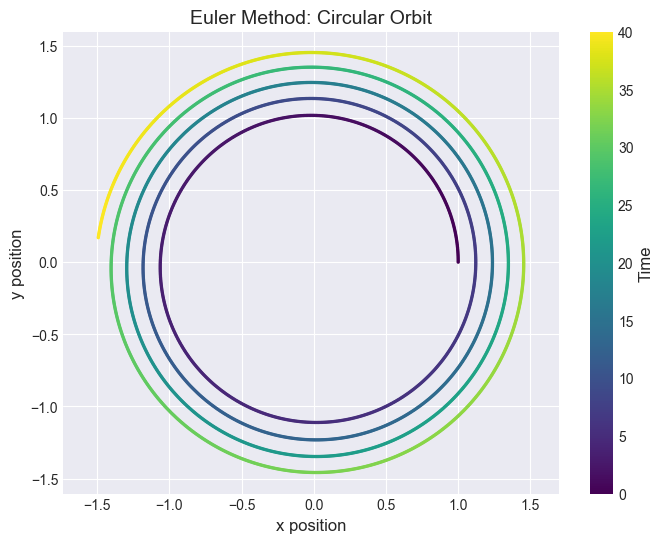

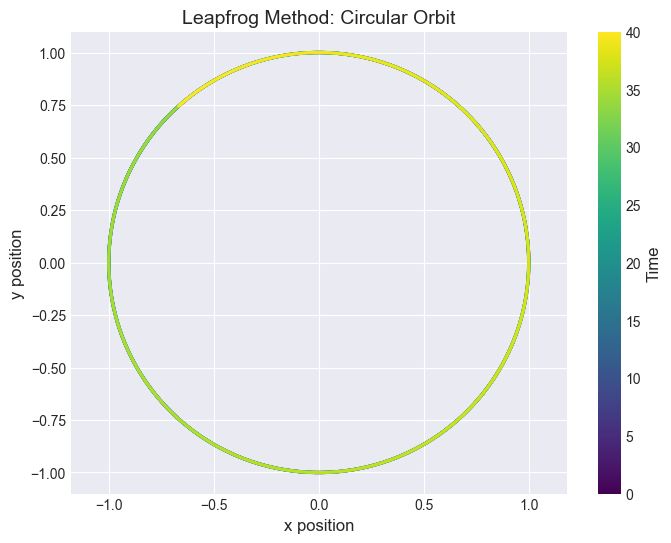

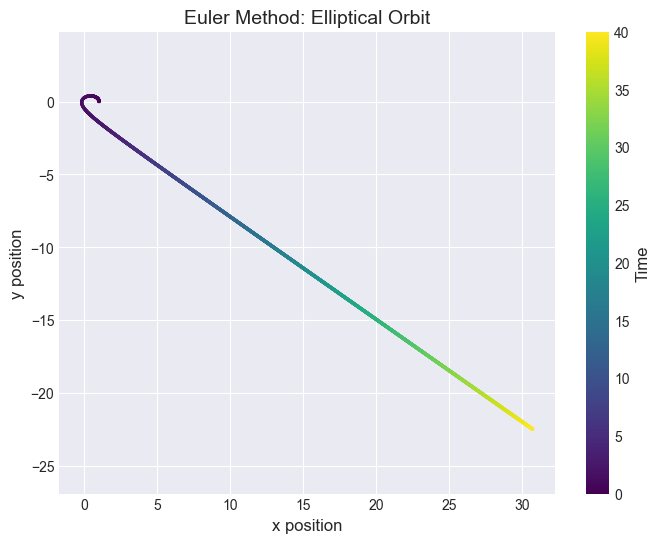

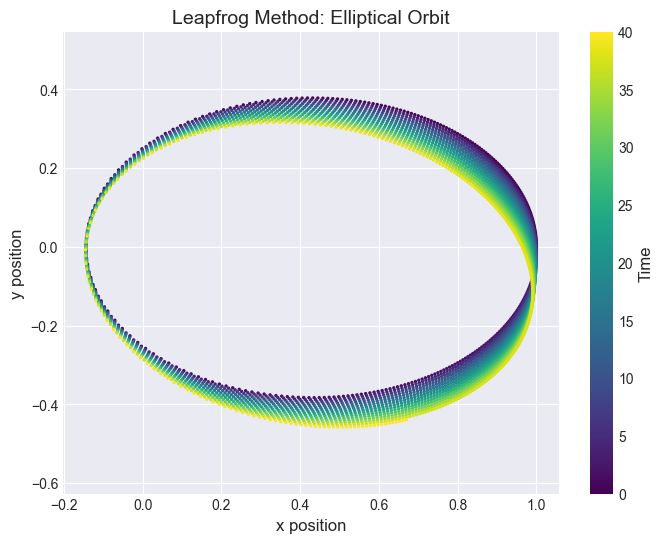

In [11]:
# Plot orbits
plot_orbit(positions_euler_circ, times_euler_circ, "Euler Method: Circular Orbit")
plot_orbit(positions_leapfrog_circ, times_leapfrog_circ, "Leapfrog Method: Circular Orbit")
plot_orbit(positions_euler_ellip, times_euler_ellip, "Euler Method: Elliptical Orbit")
plot_orbit(positions_leapfrog_ellip, times_leapfrog_ellip, "Leapfrog Method: Elliptical Orbit")

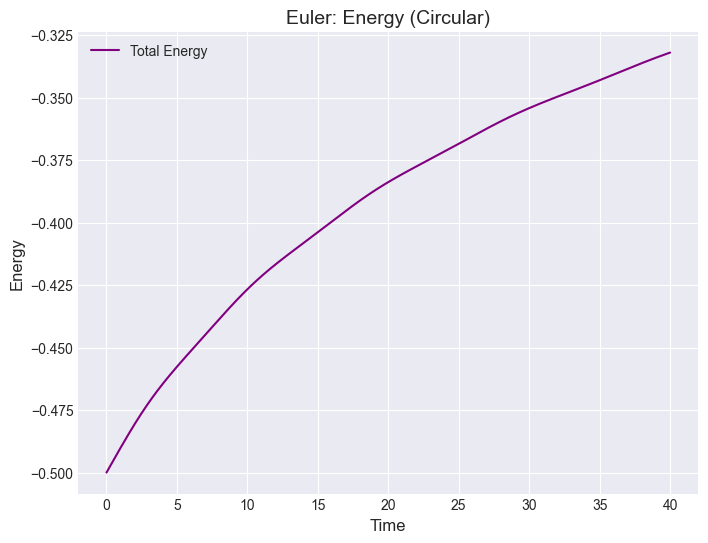

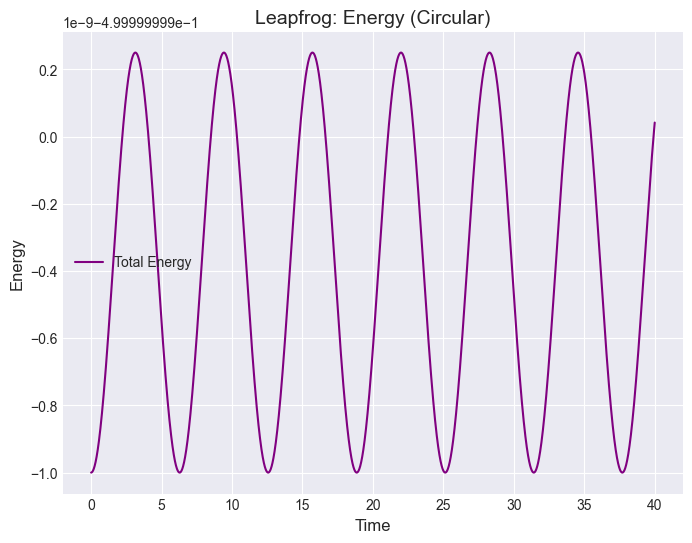

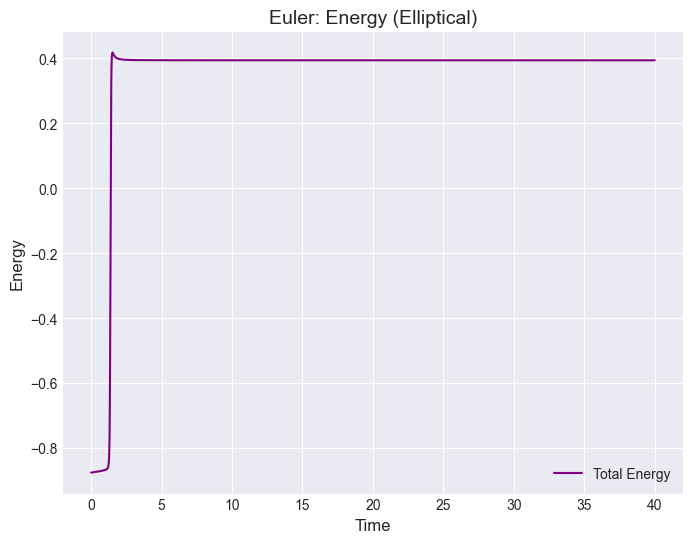

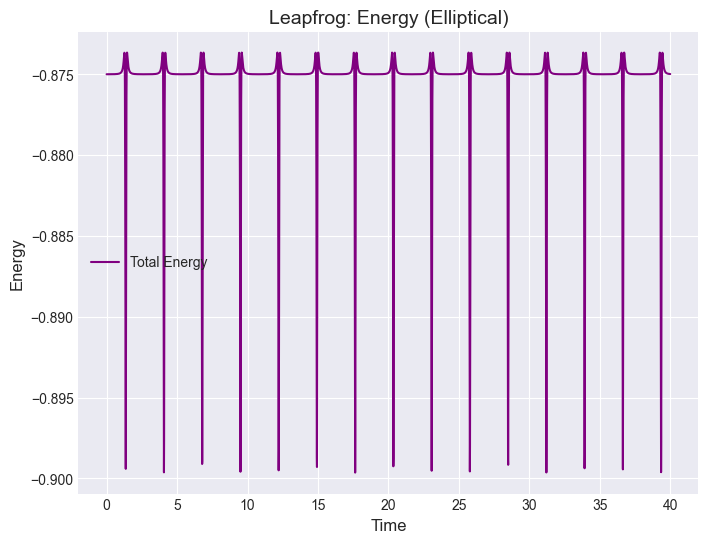

In [12]:
# Plot energy
plot_energy(positions_euler_circ, velocities_euler_circ, times_euler_circ, "Euler: Energy (Circular)")
plot_energy(positions_leapfrog_circ, velocities_leapfrog_circ, times_leapfrog_circ, "Leapfrog: Energy (Circular)")
plot_energy(positions_euler_ellip, velocities_euler_ellip, times_euler_ellip, "Euler: Energy (Elliptical)")
plot_energy(positions_leapfrog_ellip, velocities_leapfrog_ellip, times_leapfrog_ellip, "Leapfrog: Energy (Elliptical)")

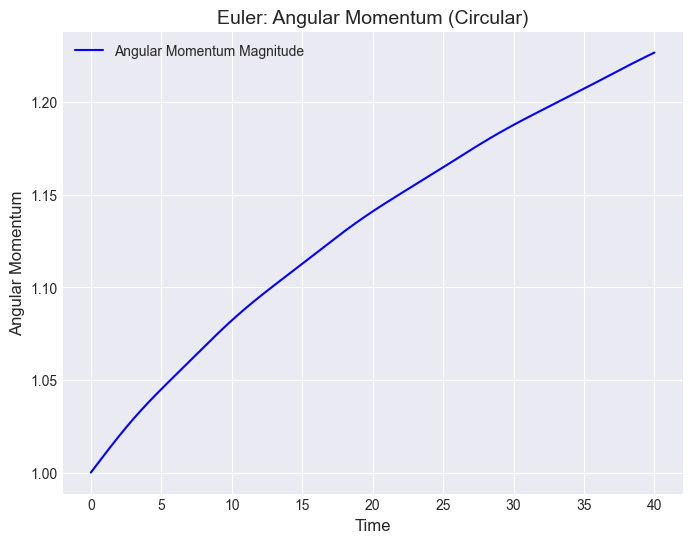

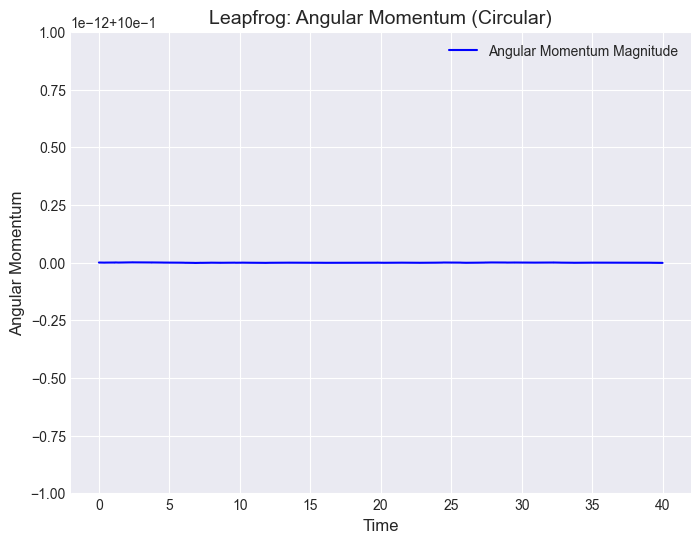

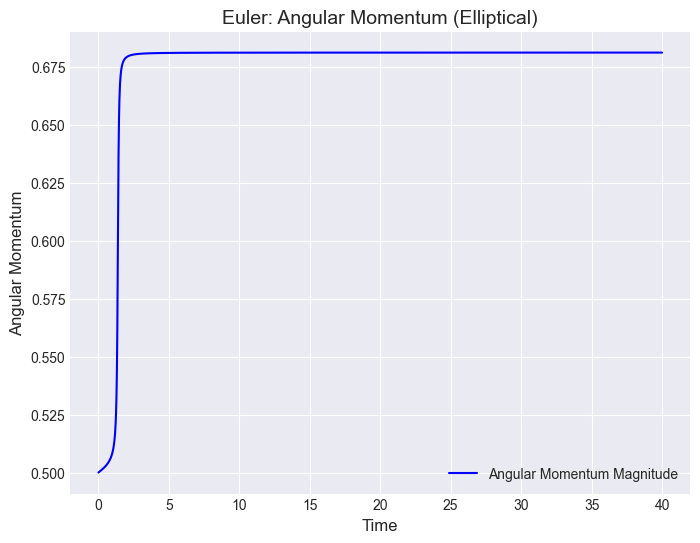

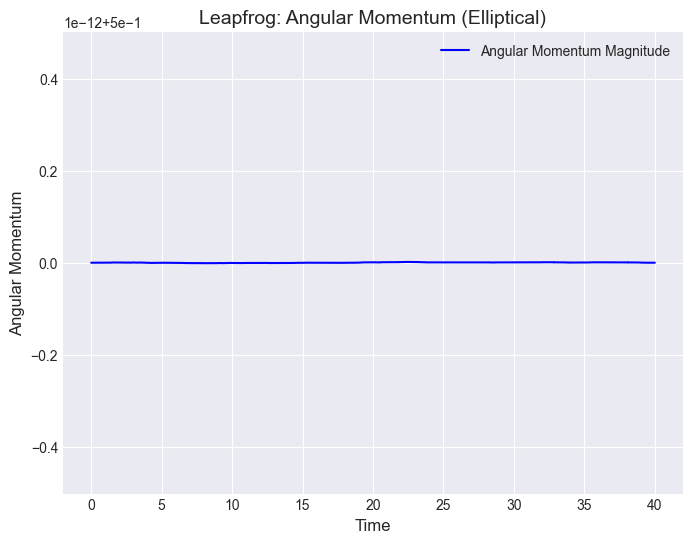

In [13]:
# Plot angular momentum
plot_angular_momentum(positions_euler_circ, velocities_euler_circ, times_euler_circ, "Euler: Angular Momentum (Circular)")
plot_angular_momentum(positions_leapfrog_circ, velocities_leapfrog_circ, times_leapfrog_circ, "Leapfrog: Angular Momentum (Circular)")
plot_angular_momentum(positions_euler_ellip, velocities_euler_ellip, times_euler_ellip, "Euler: Angular Momentum (Elliptical)")
plot_angular_momentum(positions_leapfrog_ellip, velocities_leapfrog_ellip, times_leapfrog_ellip, "Leapfrog: Angular Momentum (Elliptical)")
